# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Training stats](#Training-stats)
* [Save model and resources](#Save-model-and-resources)
* [Test model](#Test-model)

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# eventual initialization for colab notebooks
if IN_COLAB:
  # we try hard to be re-entrant,
  # that is to be able to rerun this without cloning repository more than once
  COLAB_BRANCH = "master"
  !curl https://raw.githubusercontent.com/openfoodfacts/off-category-classification/$COLAB_BRANCH/lib/colab.py --output /content/colab.py
  !cd /content && python /content/colab.py $COLAB_BRANCH
  %cd /content/off-category-classification/experiments

In [1]:
# codecarbon - start tracking
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(log_level = "WARNING", save_to_api = True, experiment_id = "6d2c8401-afba-42de-9600-6e95bea5fd80")
tracker.start()

[codecarbon ERROR @ 16:01:30] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 16:01:30] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon ERROR @ 16:01:30] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 16:01:30] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/

# Imports

In [2]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [3]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib.dataset import *
from lib.directories import init_cache_dir, init_model_dir
from lib.io import load_model, save_model
from lib.model import top_labeled_predictions, top_predictions_table
from lib.plot import plot_training_stats

2022-07-25 16:01:34.201495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 16:01:34.201549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [4]:
MODEL_BASE_DIR = pathlib.Path('../model')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value, only affects execution time

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train[:80%]'
VAL_SPLIT = 'train[80%:90%]'
TEST_SPLIT = 'train[90%:]'

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `load_dataset('off_categories', ...)` to access the dataset.

In [5]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [6]:
tf.random.set_seed(42)

## Model inputs

In [7]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [8]:
ds = load_dataset('off_categories', split=TRAIN_SPLIT)

2022-07-25 16:01:35.391724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-25 16:01:35.391761: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-25 16:01:35.391793: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alba): /proc/driver/nvidia/version does not exist
2022-07-25 16:01:35.392070: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = 93_000,
    output_sequence_length = 30)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = 64,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = 64,
    recurrent_dropout = 0.2,
    dropout = 0.0))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

CPU times: user 26.7 s, sys: 14 s, total: 40.7 s
Wall time: 7.64 s


93000

In [10]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 3,
    max_tokens = 5_000)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

CPU times: user 38.2 s, sys: 17 s, total: 55.2 s
Wall time: 9.21 s


5000

## Model output

In [11]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = 10)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)

def categories_encode(ds: tf.data.Dataset):
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )

len(categories_vocab)

CPU times: user 37.4 s, sys: 17.5 s, total: 54.8 s
Wall time: 10.5 s


5205

## Model

In [12]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs[k] for k in features], outputs=[output])

threshold = 0.5
num_labels = len(categories_vocab)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0),
    metrics = [
        tf.metrics.Precision(thresholds=threshold, name='precision'),
        tf.metrics.Recall(thresholds=threshold, name='recall'),
        tfa.metrics.F1Score(average='micro', threshold=threshold, num_classes=num_labels, name='f1_score_micro'),
        tfa.metrics.F1Score(average='macro', threshold=threshold, num_classes=num_labels, name='f1_score_macro')
    ]
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 product_name (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 30)          0           ['product_name[0][0]']           
 ization)                                                                                         
                                                                                                  
 ingredients_tags (InputLayer)  [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       5952000     ['text_vectorization[0][0]'] 

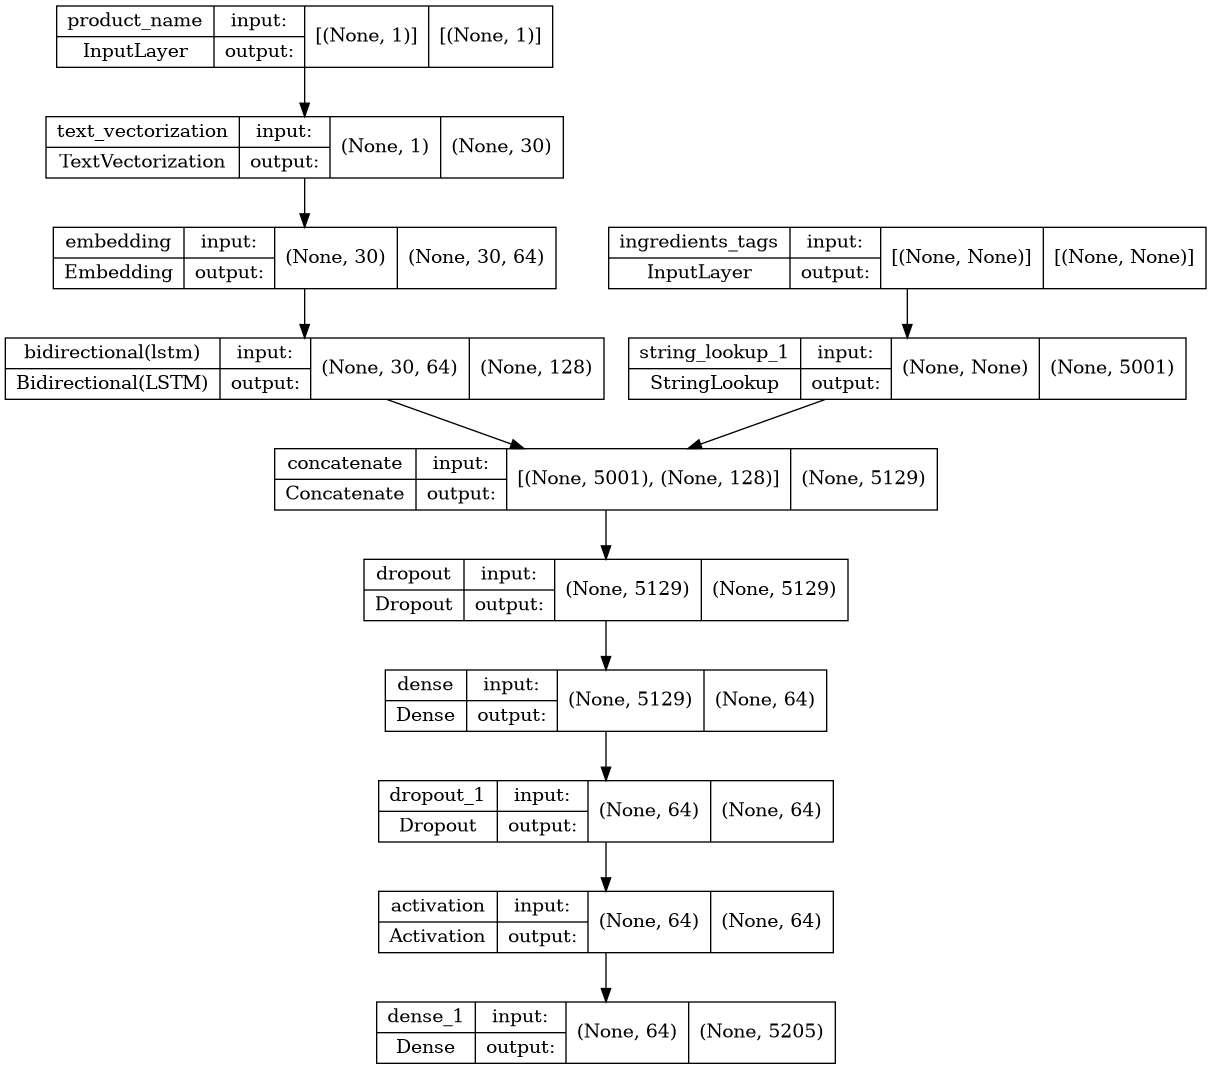

In [14]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [15]:
%%time

# Remember to clean obsolete dirs once in a while
MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
CACHE_DIR = init_cache_dir(CACHE_DIR)

batch_size = 128

ds_train = (
    load_dataset('off_categories', split=TRAIN_SPLIT, features=features, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset('off_categories', split=VAL_SPLIT, features=features, as_supervised=True)
    .apply(categories_encode)
    .padded_batch(batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = 50,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

Model directory: ../model.20220725-160202
Cache directory: ../tensorflow_cache
Epoch 1/50


2022-07-25 16:02:03.479156: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


   5250/Unknown - 498s 94ms/step - loss: 0.0072 - precision: 0.1066 - recall: 0.0438 - f1_score_micro: 0.0621 - f1_score_macro: 9.7472e-04

2022-07-25 16:10:22.408308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-07-25 16:10:40.775391: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-07-25 16:10:43.283263: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so con

INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.01-0.0036/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.01-0.0036/assets


5250/5250 [==============================] - 524s 99ms/step - loss: 0.0072 - precision: 0.1066 - recall: 0.0438 - f1_score_micro: 0.0621 - f1_score_macro: 9.7472e-04 - val_loss: 0.0036 - val_precision: 0.7909 - val_recall: 0.1629 - val_f1_score_micro: 0.2701 - val_f1_score_macro: 0.0027
Epoch 2/50
   2/5250 [..............................] - ETA: 5:34 - loss: 0.0039 - precision: 0.7356 - recall: 0.1529 - f1_score_micro: 0.2531 - f1_score_macro: 0.0019

2022-07-25 16:10:47.489539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5250/5250 [==============================] - ETA: 0s - loss: 0.0029 - precision: 0.7912 - recall: 0.3224 - f1_score_micro: 0.4581 - f1_score_macro: 0.0133INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.02-0.0020/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.02-0.0020/assets


5250/5250 [==============================] - 463s 88ms/step - loss: 0.0029 - precision: 0.7912 - recall: 0.3224 - f1_score_micro: 0.4581 - f1_score_macro: 0.0133 - val_loss: 0.0020 - val_precision: 0.8689 - val_recall: 0.4782 - val_f1_score_micro: 0.6169 - val_f1_score_macro: 0.0251
Epoch 3/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0020 - precision: 0.8288 - recall: 0.5291 - f1_score_micro: 0.6458 - f1_score_macro: 0.0438INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.03-0.0016/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.03-0.0016/assets


5250/5250 [==============================] - 433s 83ms/step - loss: 0.0020 - precision: 0.8288 - recall: 0.5291 - f1_score_micro: 0.6458 - f1_score_macro: 0.0438 - val_loss: 0.0016 - val_precision: 0.8758 - val_recall: 0.6004 - val_f1_score_micro: 0.7124 - val_f1_score_macro: 0.0598
Epoch 4/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0017 - precision: 0.8422 - recall: 0.6076 - f1_score_micro: 0.7059 - f1_score_macro: 0.0756INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.04-0.0014/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.04-0.0014/assets


5250/5250 [==============================] - 423s 81ms/step - loss: 0.0017 - precision: 0.8422 - recall: 0.6076 - f1_score_micro: 0.7059 - f1_score_macro: 0.0756 - val_loss: 0.0014 - val_precision: 0.8762 - val_recall: 0.6547 - val_f1_score_micro: 0.7494 - val_f1_score_macro: 0.0943
Epoch 5/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0015 - precision: 0.8496 - recall: 0.6480 - f1_score_micro: 0.7352 - f1_score_macro: 0.1063INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.05-0.0013/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.05-0.0013/assets


5250/5250 [==============================] - 428s 82ms/step - loss: 0.0015 - precision: 0.8496 - recall: 0.6480 - f1_score_micro: 0.7352 - f1_score_macro: 0.1063 - val_loss: 0.0013 - val_precision: 0.8783 - val_recall: 0.6823 - val_f1_score_micro: 0.7680 - val_f1_score_macro: 0.1251
Epoch 6/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0014 - precision: 0.8541 - recall: 0.6737 - f1_score_micro: 0.7532 - f1_score_macro: 0.1352INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.06-0.0013/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.06-0.0013/assets


5250/5250 [==============================] - 444s 85ms/step - loss: 0.0014 - precision: 0.8541 - recall: 0.6737 - f1_score_micro: 0.7532 - f1_score_macro: 0.1352 - val_loss: 0.0013 - val_precision: 0.8789 - val_recall: 0.7013 - val_f1_score_micro: 0.7801 - val_f1_score_macro: 0.1549
Epoch 7/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0013 - precision: 0.8584 - recall: 0.6924 - f1_score_micro: 0.7665 - f1_score_macro: 0.1617INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.07-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.07-0.0012/assets


5250/5250 [==============================] - 447s 85ms/step - loss: 0.0013 - precision: 0.8584 - recall: 0.6924 - f1_score_micro: 0.7665 - f1_score_macro: 0.1617 - val_loss: 0.0012 - val_precision: 0.8772 - val_recall: 0.7169 - val_f1_score_micro: 0.7890 - val_f1_score_macro: 0.1837
Epoch 8/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0013 - precision: 0.8617 - recall: 0.7068 - f1_score_micro: 0.7766 - f1_score_macro: 0.1834INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.08-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.08-0.0012/assets


5250/5250 [==============================] - 432s 82ms/step - loss: 0.0013 - precision: 0.8617 - recall: 0.7068 - f1_score_micro: 0.7766 - f1_score_macro: 0.1834 - val_loss: 0.0012 - val_precision: 0.8775 - val_recall: 0.7257 - val_f1_score_micro: 0.7944 - val_f1_score_macro: 0.2071
Epoch 9/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0012 - precision: 0.8640 - recall: 0.7175 - f1_score_micro: 0.7840 - f1_score_macro: 0.2031INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.09-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.09-0.0012/assets


5250/5250 [==============================] - 425s 81ms/step - loss: 0.0012 - precision: 0.8640 - recall: 0.7175 - f1_score_micro: 0.7840 - f1_score_macro: 0.2031 - val_loss: 0.0012 - val_precision: 0.8766 - val_recall: 0.7335 - val_f1_score_micro: 0.7987 - val_f1_score_macro: 0.2286
Epoch 10/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0012 - precision: 0.8662 - recall: 0.7261 - f1_score_micro: 0.7899 - f1_score_macro: 0.2200INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.10-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.10-0.0012/assets


5250/5250 [==============================] - 399s 76ms/step - loss: 0.0012 - precision: 0.8662 - recall: 0.7261 - f1_score_micro: 0.7899 - f1_score_macro: 0.2200 - val_loss: 0.0012 - val_precision: 0.8774 - val_recall: 0.7378 - val_f1_score_micro: 0.8016 - val_f1_score_macro: 0.2421
Epoch 11/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0012 - precision: 0.8684 - recall: 0.7336 - f1_score_micro: 0.7953 - f1_score_macro: 0.2368INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.11-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.11-0.0012/assets


5250/5250 [==============================] - 399s 76ms/step - loss: 0.0012 - precision: 0.8684 - recall: 0.7336 - f1_score_micro: 0.7953 - f1_score_macro: 0.2368 - val_loss: 0.0012 - val_precision: 0.8744 - val_recall: 0.7460 - val_f1_score_micro: 0.8051 - val_f1_score_macro: 0.2590
Epoch 12/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0011 - precision: 0.8697 - recall: 0.7398 - f1_score_micro: 0.7995 - f1_score_macro: 0.2503INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.12-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.12-0.0012/assets


5250/5250 [==============================] - 397s 76ms/step - loss: 0.0011 - precision: 0.8697 - recall: 0.7398 - f1_score_micro: 0.7995 - f1_score_macro: 0.2503 - val_loss: 0.0012 - val_precision: 0.8771 - val_recall: 0.7456 - val_f1_score_micro: 0.8060 - val_f1_score_macro: 0.2662
Epoch 13/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0011 - precision: 0.8711 - recall: 0.7452 - f1_score_micro: 0.8032 - f1_score_macro: 0.2627INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.13-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.13-0.0012/assets


5250/5250 [==============================] - 397s 76ms/step - loss: 0.0011 - precision: 0.8711 - recall: 0.7452 - f1_score_micro: 0.8032 - f1_score_macro: 0.2627 - val_loss: 0.0012 - val_precision: 0.8757 - val_recall: 0.7492 - val_f1_score_micro: 0.8076 - val_f1_score_macro: 0.2778
Epoch 14/50
5250/5250 [==============================] - ETA: 0s - loss: 0.0011 - precision: 0.8721 - recall: 0.7497 - f1_score_micro: 0.8063 - f1_score_macro: 0.2730INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.14-0.0012/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/weights.14-0.0012/assets


5250/5250 [==============================] - 441s 84ms/step - loss: 0.0011 - precision: 0.8721 - recall: 0.7497 - f1_score_micro: 0.8063 - f1_score_macro: 0.2730 - val_loss: 0.0012 - val_precision: 0.8760 - val_recall: 0.7510 - val_f1_score_micro: 0.8087 - val_f1_score_macro: 0.2857
Epoch 15/50
5250/5250 [==============================] - 455s 87ms/step - loss: 0.0011 - precision: 0.8736 - recall: 0.7540 - f1_score_micro: 0.8094 - f1_score_macro: 0.2831 - val_loss: 0.0012 - val_precision: 0.8767 - val_recall: 0.7519 - val_f1_score_micro: 0.8095 - val_f1_score_macro: 0.2953
Epoch 16/50
5250/5250 [==============================] - 437s 83ms/step - loss: 0.0011 - precision: 0.8745 - recall: 0.7577 - f1_score_micro: 0.8120 - f1_score_macro: 0.2929 - val_loss: 0.0012 - val_precision: 0.8753 - val_recall: 0.7551 - val_f1_score_micro: 0.8107 - val_f1_score_macro: 0.2995
Epoch 17/50
5250/5250 [==============================] - 433s 83ms/step - loss: 0.0010 - precision: 0.8753 - recall: 0.7607 

## Training stats

In [16]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

,epoch,f1_score_macro,f1_score_micro,loss,precision,recall,val_f1_score_macro,val_f1_score_micro,val_loss,val_precision,val_recall
0,0,0.000975,0.062128,0.007167,0.106605,0.043838,0.002726,0.270136,0.003561,0.790913,0.162885
1,1,0.013316,0.458145,0.002938,0.791225,0.322417,0.025131,0.616862,0.002039,0.868896,0.478164
2,2,0.043801,0.645833,0.001997,0.828776,0.529051,0.059764,0.712394,0.001606,0.875782,0.600384
3,3,0.075553,0.705915,0.001667,0.842227,0.607580,0.094288,0.749412,0.001422,0.876189,0.654686
4,4,0.106317,0.735244,0.001498,0.849599,0.648020,0.125073,0.767977,0.001324,0.878287,0.682285
5,5,0.135163,0.753216,0.001393,0.854053,0.673676,0.154873,0.780148,0.001271,0.878943,0.701318
6,6,0.161660,0.766495,0.001318,0.858360,0.692392,0.183745,0.788985,0.001233,0.877227,0.716873
7,7,0.183383,0.776602,0.001262,0.861749,0.706768,0.207052,0.794414,0.001211,0.877463,0.725726
8,8,0.203071,0.783962,0.001217,0.863979,0.717510,0.228642,0.798723,0.001194,0.876640,0.733526
9,9,0.219971,0.789949,0.001184,0.866158,0.726066,0.242096,0.801588,0.001184,0.877389,0.737842


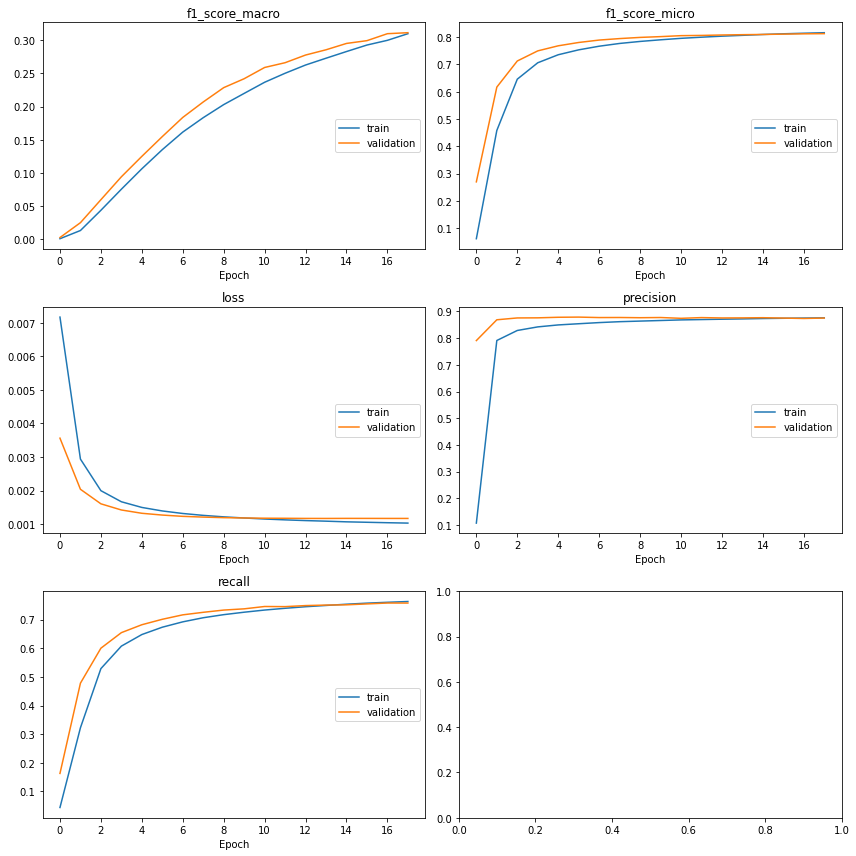

In [17]:
plot_training_stats(stats)

# Save model and resources

In [18]:
SAVED_MODEL_DIR = MODEL_DIR / 'saved_model'

@tf.function
def serving_func(*args, **kwargs):
    preds = model(*args, **kwargs)
    return top_labeled_predictions(preds, categories_vocab, k=50)

save_model(SAVED_MODEL_DIR, model, categories_vocab, serving_func)

INFO:tensorflow:Assets written to: ../model.20220725-160202/saved_model/assets


INFO:tensorflow:Assets written to: ../model.20220725-160202/saved_model/assets


# Test model

In [19]:
m, labels = load_model(SAVED_MODEL_DIR)

In [20]:
ds_test = load_dataset('off_categories', split=TEST_SPLIT)

In [21]:
%%time

preds_test = m.predict(ds_test.padded_batch(128))
preds_test

/home/gabriel/.pyenv/versions/3.8.13/envs/venv-off-tf28/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-07-25 18:12:40.445804: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1785523200 exceeds 10% of free system memory.


CPU times: user 31.4 s, sys: 8.41 s, total: 39.8 s
Wall time: 8.79 s


array([[9.2338169e-01, 9.1812074e-01, 1.1689961e-03, ..., 2.3601480e-08,
        2.7538024e-07, 3.2840742e-08],
       [8.8147974e-01, 8.7351203e-01, 2.8353930e-04, ..., 7.5147000e-11,
        3.8100993e-09, 6.3007155e-07],
       [9.7078896e-01, 9.7021067e-01, 1.7446170e-07, ..., 6.8437152e-14,
        1.2844977e-12, 3.3839781e-10],
       ...,
       [2.1886206e-01, 2.0773542e-01, 1.7316398e-01, ..., 6.1721825e-05,
        7.0206559e-05, 6.2197316e-05],
       [4.1987896e-03, 7.6553226e-04, 6.0066777e-05, ..., 5.4362738e-12,
        3.2658498e-10, 2.5570373e-06],
       [2.3281223e-06, 2.7602388e-07, 9.1620833e-01, ..., 2.8868532e-08,
        4.4399904e-11, 1.9896805e-13]], dtype=float32)

In [22]:
# This is the function exported as the default serving function in our saved model
top_preds_test = top_labeled_predictions(preds_test, labels, k=3)
top_preds_test

2022-07-25 18:12:42.998211: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1785523200 exceeds 10% of free system memory.


(<tf.Tensor: shape=(85760, 3), dtype=float32, numpy=
 array([[0.9491619 , 0.9342787 , 0.9293441 ],
        [0.91675323, 0.8837776 , 0.88147974],
        [0.97430325, 0.97078896, 0.9702107 ],
        ...,
        [0.23283073, 0.21886206, 0.20773542],
        [0.956066  , 0.94531786, 0.94348717],
        [0.9699911 , 0.9192833 , 0.9162083 ]], dtype=float32)>,
 <tf.Tensor: shape=(85760, 3), dtype=string, numpy=
 array([[b'en:spreads', b'en:fruit-and-vegetable-preserves',
         b'en:plant-based-spreads'],
        [b'en:fruits-and-vegetables-based-foods', b'en:compotes',
         b'en:plant-based-foods-and-beverages'],
        [b'en:fruits-and-vegetables-based-foods',
         b'en:plant-based-foods-and-beverages', b'en:plant-based-foods'],
        ...,
        [b'en:beverages', b'en:plant-based-foods-and-beverages',
         b'en:plant-based-foods'],
        [b'en:dairies', b'en:fermented-foods',
         b'en:fermented-milk-products'],
        [b'en:cocoa-and-its-products', b'en:sweet-

In [23]:
# Same data, but pretty
pred_table_test = top_predictions_table(top_preds_test)

# Add some interpretable features to the final table
# Table must be row-aligned with predictions above (= taken from same data sample)
extra_cols_test = as_dataframe(select_features(ds_test, ['code', 'product_name']))

pd.concat([extra_cols_test, pred_table_test], axis=1)

,code,product_name,top prediction 1,top prediction 2,top prediction 3
0,0637793029422,Blueberry preserve,en:spreads: 94.92%,en:fruit-and-vegetable-preserves: 93.43%,en:plant-based-spreads: 92.93%
1,5400141381191,Mousseline de pommes,en:fruits-and-vegetables-based-foods: 91.68%,en:compotes: 88.38%,en:plant-based-foods-and-beverages: 88.15%
2,3250392084080,Choux-Fleurs Bio,en:fruits-and-vegetables-based-foods: 97.43%,en:plant-based-foods-and-beverages: 97.08%,en:plant-based-foods: 97.02%
3,8425275510085,Aceite de oliva virgen extra,en:fats: 99.91%,en:plant-based-foods-and-beverages: 99.90%,en:plant-based-foods: 99.89%
4,4260193516047,Yörem Ayran,en:beverages: 93.01%,en:fermented-foods: 78.44%,en:fermented-milk-products: 76.72%
...,...,...,...,...,...
85755,8410500021757,Oikos tentaciones tarta de arándanos,en:fermented-foods: 96.50%,en:dairies: 95.54%,en:fermented-milk-products: 94.57%
85756,0810176020524,Beef jerky,en:snacks: 65.96%,en:beef-jerkies: 55.97%,en:meats: 55.51%
85757,4820003487471,ідеаль немолоко вівсяне,en:beverages: 23.28%,en:plant-based-foods-and-beverages: 21.89%,en:plant-based-foods: 20.77%
85758,7613269520931,Mozzarella,en:dairies: 95.61%,en:fermented-foods: 94.53%,en:fermented-milk-products: 94.35%


In [24]:
# codecarbon - stop tracking
tracker.stop()

1.4188378674816378e-05